# Machine Learning Project 1


In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.model_selection import KFold, RepeatedKFold, train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, get_scorer_names
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from scipy.stats.mstats import winsorize

In [2]:
# import scikeras
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings('ignore', message='Setting the random state for TF')

from scikeras.wrappers import KerasRegressor
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense
from tensorflow.keras import regularizers
import tensorflow as tf
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
# Import matplotlib for graphs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

# Set global parameters
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (12,5)
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

## Import and prepare data

In [4]:
# load data
train = pd.read_csv('training.csv', index_col='id')
test = pd.read_csv('X_test.csv', index_col='id')

test_Y = pd.read_csv('Y_test_example.csv', index_col='id')
# for the submission, overwrite all y value with na
# will populate with our prediction later
test_Y['rent_full'] = np.nan

train.head()

,GDENAMK,GDENR,KTKZ,address,area,balcony,basement,bath,cabletv,cheminee,...,dist_to_5G,dist_to_haltst,dist_to_highway,dist_to_lake,dist_to_main_stat,dist_to_school_1,dist_to_train_stat,restaur_pix_count_km2,superm_pix_count_km2,dist_to_river
id,,,,,,,,,,,,,,,,,,,,,
1,Chavornay,5749,VD,"Rue de Sadaz 15, 1373 Chavornay",80.0,NaN,NaN,NaN,NaN,NaN,...,12760.941970,542.609436,845.529420,NaN,542.609436,39.051248,542.609436,0,0,1232.655713
2,Grenchen,2546,SO,"Viaduktstrasse 8, 2540 Grenchen",90.0,1.0,NaN,NaN,1.0,NaN,...,8755.851529,78.517514,2880.772987,NaN,850.367568,413.146463,535.210239,7,0,1124.472721
3,Vevey,5890,VD,1800 Vevey,32.0,NaN,NaN,NaN,NaN,NaN,...,6926.931211,21.931712,2209.414402,166.042100,302.702825,140.035710,302.702825,45,5,6661.799045
4,Bern,351,BE,"Spitalackerstrasse 16, 3013 Bern BE",77.0,1.0,NaN,NaN,1.0,NaN,...,869.835042,69.462220,1390.906539,3528.066226,1537.693077,332.987988,1537.693077,11,3,438.552999
5,Winterthur,230,ZH,"Im Geissacker 40, 8404 Winterthur",NaN,1.0,NaN,NaN,1.0,NaN,...,575.800313,92.849340,2169.393694,2178.792308,2983.516382,136.619911,352.512411,2,2,897.649851


In [5]:
# train.drop_duplicates() 
# no duplicates found. good!

In [6]:
# summary statistics
train.describe()

,GDENR,area,balcony,basement,bath,cabletv,cheminee,dishwasher,dryer,elevator,...,dist_to_5G,dist_to_haltst,dist_to_highway,dist_to_lake,dist_to_main_stat,dist_to_school_1,dist_to_train_stat,restaur_pix_count_km2,superm_pix_count_km2,dist_to_river
count,72000.000000,57767.000000,34520.0,976.0,496.0,24906.0,3330.0,1178.0,572.0,21939.0,...,72000.000000,71492.000000,72000.000000,38262.000000,50571.000000,71498.000000,72000.000000,72000.000000,72000.000000,72000.000000
mean,2879.512722,82.959233,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,7638.035391,166.852546,2922.607580,1864.570974,1236.536863,396.477677,1057.297004,11.650417,1.721319,823.578550
std,2199.443778,34.487208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12363.592303,174.026725,3228.381560,5873.068385,1155.591313,355.310688,1158.211097,22.482845,2.219454,968.968316
min,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.236068,2.828427,11.401754,4.638762,3.605551,1.414214,3.162278,0.000000,0.000000,0.041264
25%,404.000000,60.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1323.998583,78.873316,1145.318296,576.187827,474.067506,204.732142,374.001003,1.000000,0.000000,224.010704
50%,2766.000000,80.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,3529.439957,130.387883,1984.648834,1204.365110,885.849874,327.678196,684.942698,3.000000,1.000000,515.221416
75%,4776.000000,101.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,9033.896515,202.141040,3410.488088,2176.086622,1613.165521,473.608488,1243.497085,9.000000,3.000000,1065.183279
max,6810.000000,945.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,88563.904680,4967.810886,41454.525950,205028.994100,15405.006360,7534.579285,23787.109950,136.000000,12.000000,8233.113960


In [7]:
# how many non-missing values per feature
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72000 entries, 1 to 72000
Data columns (total 82 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   GDENAMK                         72000 non-null  object 
 1   GDENR                           72000 non-null  int64  
 2   KTKZ                            72000 non-null  object 
 3   address                         72000 non-null  object 
 4   area                            57767 non-null  float64
 5   balcony                         34520 non-null  float64
 6   basement                        976 non-null    float64
 7   bath                            496 non-null    float64
 8   cabletv                         24906 non-null  float64
 9   cheminee                        3330 non-null   float64
 10  date                            72000 non-null  object 
 11  descr                           51473 non-null  object 
 12  dishwasher                      

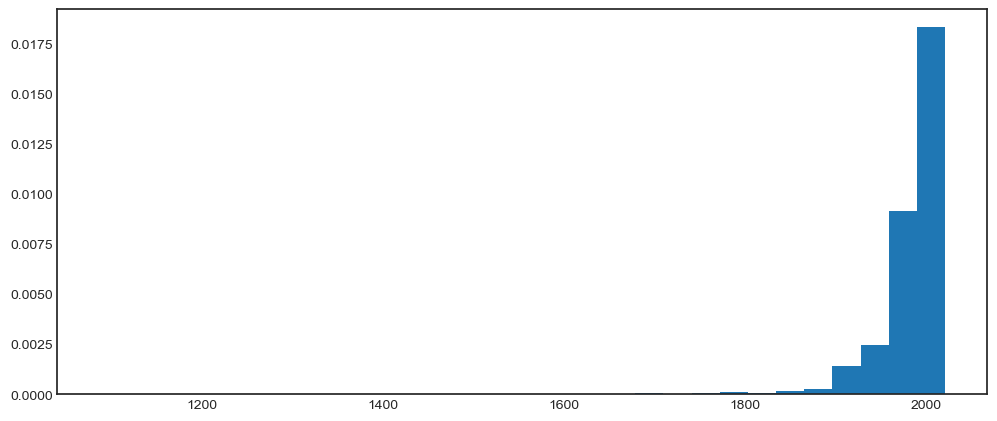

In [8]:
# plt.hist(np.log2(train['year_built']), bins=30, density=True)
plt.hist(train['year_built'], bins=30, density=True)
plt.show()

<AxesSubplot:xlabel='rooms', ylabel='area'>

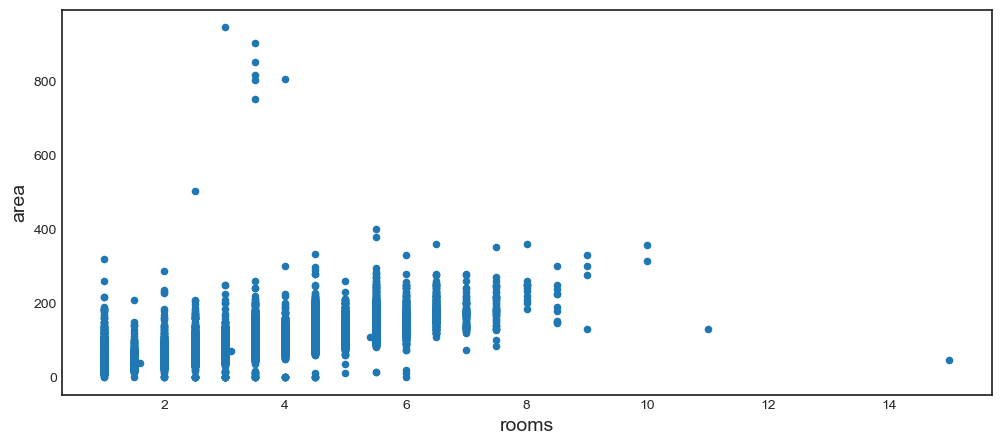

In [9]:
train.plot.scatter(x='rooms', y='area')

In [10]:
def prepare_clean_data(data):
    df = data.drop(['GDENAMK', 'year', 'date', 'lat', 'lon', ], axis=1)
    # GDENAMK, we have id: GDENR, we use msregion as best location indicator.
    # quarter_specific not needed, we have year and quarter (and date) already
    # 'year' listed is always 2019, redundant

    # drop least useful location indicator
    df = df.drop(['GDENR', 'KTKZ', 'address'], axis=1)

    # drop dummy columns with many missing values
    # dropped due to low data quality => low predictive power
    # floors has negative values and quite a few missing.
    df = df.drop(['basement', 'bath', 'cheminee', 'dishwasher', 'dryer', 
                'furnished', 'gardenshed', 'heating_air', 'heating_earth', 
                'heating_electro', 'heating_far', 'heating_gas', 'heating_oil', 
                'heating_pellets', 'kids_friendly', 'laundry', 'manlift', 'middle_house', 
                'oven', 'playground', 'pool', 'quiet', 'raised_groundfloor', 'shower',
                'sunny', 'terrace', 'toilets', 'topstorage', 'veranda', 'water', 'oldbuilding', ], axis=1)

    # the following have over 10'000 positive answers. We keep for the prediction.
    for c in ['balcony', 'cabletv', 'elevator', 'parking_indoor', 'parking_outside', ]:
        df[c] = np.where(np.isnan(df[c]), 0, 1)

    # impute area based on msregion, home_type, and number of rooms => median b.c. outliers in area
    df['area'] = df['area'].fillna(df.groupby(['home_type', 'rooms',])['area'].transform('median'))

    # # replace description text with dummy, if description exists or not
    df = df.astype({'descr': str})
    df['descr'] = np.where(df.descr=='nan', 0, df.descr.str.len())

    # has any parking
    df['parking_any'] = np.where((df.parking_indoor==1) & (df.parking_outside==1), 0, 1)

    # impute floors with average
    df['floors'] = df['floors'].fillna(df['avg_anzhl_geschosse'])

    # impute year_built
    df['year_built'] = np.where(df['year_built']==-1 , np.nan, df['year_built'])
    df['year_built'] = df['year_built'].fillna(df['avg_bauperiode'])
    df['year_built'] = df['year_built']**20 # fix left skew

    # log transform right skewed distributions
    for f in ['Noise_max', 'dist_to_4G', 'dist_to_5G']:
        df[f] = df[f]+1

    for f in ['wgh_avg_sonnenklasse_per_egid', 'Avg_age', 'Avg_size_household',
            'Noise_max', 'avg_anzhl_geschosse', 'dist_to_4G', 
            'dist_to_5G','dist_to_haltst', 'dist_to_river' ]:
        df[f] = np.log(df[f])

    # standardize non-dummy features
    # winsorize some variables with outliers
    for f in ['Micro_rating', 'Micro_rating_NoiseAndEmission', 'Micro_rating_Accessibility',
              'Micro_rating_DistrictAndArea', 'Micro_rating_SunAndView', 'Micro_rating_ServicesAndNature',
              'wgh_avg_sonnenklasse_per_egid', 'Anteil_auslaend', 'Avg_age', 'Avg_size_household',
              'Avg_size_household', 'Noise_max', 'avg_anzhl_geschosse', 'avg_bauperiode',
              'dist_to_4G', 'dist_to_5G', 'dist_to_haltst', 'dist_to_highway', 'dist_to_school_1',
              'dist_to_train_stat', 'dist_to_river', 'year_built']:
        df[f] = winsorize(df[f], limits=[0.03, 0.03], nan_policy='propagate')   

    # the following variables are categorical or the numerical representation is not meaningful 
    # (e.g. larger numbers not systematically different from smaller numbers)
    # transform into dummies
    for f in ['msregion', 'home_type', 'rooms']:
        dummies = pd.get_dummies(df[f], prefix=str(f), drop_first=False) 
        df = df.merge(dummies, left_index=True, right_index=True)
        df = df.drop(f, axis=1) # drop the original variable

    # other vars we don't want, mostly because too little data or no meaningful improvement by including
    df = df.drop(['dist_to_lake', 'dist_to_main_stat', 'quarter_specific', 
                'quarter_general', 'month', 'anteil_efh', 'avg_anzhl_geschosse', 
                'avg_bauperiode', ], axis=1)

    return df

In [11]:
# clean data
df_train = prepare_clean_data(train)
df_test = prepare_clean_data(test)

# ensure test data has all the right columns
# Get missing columns in the training test
missing_cols = set( df_train.columns ) - set( df_test.columns )

# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    df_test[c] = 0 # constant

# Ensure the order of column in the test set is in the same order than in train set
df_test = df_test[df_train.columns]
df_test = df_test.drop('rent_full', axis=1)


In [12]:
# standardize train and test data (except the dummies)
cols_to_scale = ['area',
                 'Micro_rating', 'Micro_rating_NoiseAndEmission', 'Micro_rating_Accessibility',
                 'wgh_avg_sonnenklasse_per_egid', 'Anteil_auslaend', 'Avg_age', 'Avg_size_household',
                 'Avg_size_household', 'Noise_max', 'descr', 'dist_to_4G', 'dist_to_5G',
                 'dist_to_haltst', 'dist_to_highway', 'dist_to_school_1',
                 'dist_to_train_stat', 'dist_to_river', 'year_built' ]

scaler = StandardScaler()
scaler.fit(df_train[cols_to_scale])
df_train[cols_to_scale] = scaler.transform(df_train[cols_to_scale])

# scale test data with the fit from train data
df_test[cols_to_scale] = scaler.transform(df_test[cols_to_scale])

In [13]:
# handle rows with missing data
    
# training    
df_train = df_train.dropna()

# testing
temp = df_test.copy()
df_test = temp.dropna() # we only predict on the rows that are possible

# we safe the index of the test data for which we have missing data
df_test_missing = temp.merge(df_test, left_index=True, right_index=True, how='left', indicator=True)
df_test_missing = df_test_missing[df_test_missing['_merge'] == 'left_only']
df_test_missing = df_test_missing[[]] # only keep the index column

## Training

In [14]:
# train values for X and y
X = df_train.drop(['rent_full'], axis=1).values
y = df_train.rent_full.values

In [15]:
# set aside validation data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1)
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_valid:", X_valid.shape)
print("Shape of y_valid:", y_valid.shape)

Shape of X_train: (55255, 168)
Shape of y_train: (55255,)
Shape of X_valid: (13814, 168)
Shape of y_valid: (13814,)


### OLS

In [16]:
scores = cross_val_score(LinearRegression(), X_train, y_train, scoring='neg_mean_squared_error', cv=KFold(n_splits=10))
avg_score = np.mean(scores)
print(f'Features: {len(df_train.columns)-1}, Obs: {len(df_train):_}, MSE: {int(-1*avg_score):_}'.replace('_', "'"))

# all 'bad' dummies included and NA coded as 0, Msregion only
# =>                                                    Features: 214, Obs: 55'209, MSE: 361'972'499'893

# No 'bad' dummies                                      Features: 177, Obs: 55'209, MSE: 142'565
# some 'bad' dummies (>10'000 responses)                Features: 182, Obs: 55'209, MSE: 139'787

# msregion and KTKZ:                                    Features: 208, Obs: 55'209, MSE: 139'779
# ==> msregion only b.c. fewer features

# area imputed (type, rooms):                           Features: 182, Obs: 68'136, MSE: 141'183
# area imputed (msregion, type, rooms):                 Features: 182, Obs: 67'890, MSE: 140'556
# ==> more observations. keep
# ==> TODO, which one better? kept the one without msregion

# added dummy for description                           Features: 183, Obs: 68'136, MSE: 141'173
# added description length                              Features: 183, Obs: 68'136, MSE: 140'855
# description length helpful 

# dummy for any parking                                 Features: 184, Obs: 68'136, MSE: 140'849
# slightly better

# quarter and month of listing ignored.                 Features: 169, Obs: 68'136, MSE: 140'886
# ==> same mse with fewer features

# drop anteil_efh                                       Features: 168, Obs: 68'136, MSE: 140'881

# standardize vars:                                     Features: 168, Obs: 68'136, MSE: 140'881
# ==> no impact, as expected

# log transform for better normal distribution          Features: 168, Obs: 68'136, MSE: 140'727
# => slightly better
# log of area makes mse much worse. too much discounted

# winsorize all (expect area)
# (3%, 3%):                                             Features: 168, Obs: 69'069, MSE: 140'595
# (5%, 5%):                                             Features: 168, Obs: 71'276, MSE: 143'470
# (1%, 1%):                                             Features: 168, Obs: 69'069, MSE: 140'637
# => 3% symmetric winsorization

# impute floors from average_geschosse and drop that average
#                                                        Features: 168, Obs: 69'069, MSE: 140'549       
# ==> floors could be better than average, as more precise, use that 

# impute year_built from average and drop said average
#                                                        Features: 168, Obs: 69'069, MSE: 140'504
# with left skew corrected and standardized              Features: 168, Obs: 69'069, MSE: 139'987

Features: 168, Obs: 69'069, MSE: 139'574


In [17]:
# fit OLS model
ols = LinearRegression().fit(X_train, y_train)
y_hat = ols.predict(X_valid)
print(f'Features: {len(df_train.columns)-1}, Obs: {len(df_train):_}, MSE: {int(mean_squared_error(y_valid, y_hat)):_}'.replace('_', "'"))

Features: 168, Obs: 69'069, MSE: 142'652


In [18]:
showcase = pd.DataFrame(y_hat, y_valid)

## Random Forest

In [19]:
# Create the random grid
parameters = {'n_estimators': [500, 750, 1000],
               'max_depth': [100, 150, None],
               'min_samples_split': [1, 5, 10],
               'min_samples_leaf': [1, 5, 10],
               'criterion': ['squared_error'],}

In [20]:
# for random search use a very small subset of train data
X_trn, _, y_trn, _ = train_test_split(X_train, y_train, train_size=0.05, shuffle=True, random_state=1)

In [21]:
rf = RandomForestRegressor(n_jobs = -1)
# pick 81 potential subjects
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = parameters, n_iter = 81, cv = 3, verbose=2, random_state=42)
# Fit the random search model
rf_random.fit(X_trn, y_trn)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


/Users/beat/opt/miniconda3/envs/ENV_ML/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END criterion=squared_error, max_depth=100, min_samples_leaf=1, min_samples_split=1, n_estimators=500; total time=   1.5s
[CV] END criterion=squared_error, max_depth=100, min_samples_leaf=1, min_samples_split=1, n_estimators=500; total time=   1.4s
[CV] END criterion=squared_error, max_depth=100, min_samples_leaf=1, min_samples_split=1, n_estimators=500; total time=   1.5s
[CV] END criterion=squared_error, max_depth=100, min_samples_leaf=1, min_samples_split=1, n_estimators=750; total time=   1.7s
[CV] END criterion=squared_error, max_depth=100, min_samples_leaf=1, min_samples_split=1, n_estimators=750; total time=   1.4s
[CV] END criterion=squared_error, max_depth=100, min_samples_leaf=1, min_samples_split=1, n_estimators=750; total time=   1.3s
[CV] END criterion=squared_error, max_depth=100, min_samples_leaf=1, min_samples_split=1, n_estimators=1000; total time=   1.3s
[CV] END criterion=squared_error, max_depth=100, min_samples_leaf=1, min_samples_split=1, n_estimators=1000; t

/Users/beat/opt/miniconda3/envs/ENV_ML/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
81 fits failed out of a total of 243.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
81 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/Users/beat/opt/miniconda3/envs/ENV_ML/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py", line 436, in _process_worker
    r = call_item()
  File "/Users/beat/opt/miniconda3/envs/ENV_ML/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py", line 288, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "/Users/beat/opt/miniconda3/

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1), n_iter=100,
                   param_distributions={'criterion': ['squared_error'],
                                        'max_depth': [100, 150, None],
                                        'min_samples_leaf': [1, 5, 10],
                                        'min_samples_split': [1, 5, 10],
                                        'n_estimators': [500, 750, 1000]},
                   random_state=42, verbose=2)

In [22]:
rf_random.best_params_

{'n_estimators': 750,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_depth': None,
 'criterion': 'squared_error'}

In [23]:
# pick in the region of the best random parameters to fine tune.
# Create the random grid
parameters = {'n_estimators': [700, 750, 800],
               'max_depth': [200, None],
               'min_samples_split': [4, 5, 6],
               'min_samples_leaf': [1, 2],
               'criterion': ['squared_error'],}

In [24]:
#passing the scoring function in the GridSearchCV
grid = GridSearchCV(RandomForestRegressor(n_jobs=-1), parameters, refit=False, cv=3, verbose=2)


In [25]:
grid_result = grid.fit(X_train, y_train) # here we fit with all training data

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END criterion=squared_error, max_depth=200, min_samples_leaf=1, min_samples_split=4, n_estimators=700; total time= 1.1min
[CV] END criterion=squared_error, max_depth=200, min_samples_leaf=1, min_samples_split=4, n_estimators=700; total time= 1.0min
[CV] END criterion=squared_error, max_depth=200, min_samples_leaf=1, min_samples_split=4, n_estimators=700; total time= 1.0min
[CV] END criterion=squared_error, max_depth=200, min_samples_leaf=1, min_samples_split=4, n_estimators=750; total time= 1.1min
[CV] END criterion=squared_error, max_depth=200, min_samples_leaf=1, min_samples_split=4, n_estimators=750; total time= 1.1min
[CV] END criterion=squared_error, max_depth=200, min_samples_leaf=1, min_samples_split=4, n_estimators=750; total time= 1.1min
[CV] END criterion=squared_error, max_depth=200, min_samples_leaf=1, min_samples_split=4, n_estimators=800; total time= 1.2min
[CV] END criterion=squared_error, max_depth=200, 

In [26]:
grid_result.best_params_

{'criterion': 'squared_error',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 700}

In [27]:
model = RandomForestRegressor(n_estimators= grid_result.best_params_["n_estimators"],
                              max_depth= grid_result.best_params_["max_depth"],
                              min_samples_split= grid_result.best_params_["min_samples_split"],
                              min_samples_leaf= grid_result.best_params_["min_samples_leaf"] ,
                              verbose=2,
                              n_jobs=-1,
                                    )

In [28]:
history = model.fit(X_train, y_train)

building tree 1 of 700building tree 2 of 700

building tree 3 of 700
building tree 4 of 700
building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700
building tree 28 of 700
building tree 29 of 700
building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.1s


building tree 41 of 700
building tree 42 of 700
building tree 43 of 700
building tree 44 of 700
building tree 45 of 700
building tree 46 of 700
building tree 47 of 700
building tree 48 of 700
building tree 49 of 700
building tree 50 of 700
building tree 51 of 700
building tree 52 of 700
building tree 53 of 700
building tree 54 of 700
building tree 55 of 700
building tree 56 of 700
building tree 57 of 700
building tree 58 of 700
building tree 59 of 700
building tree 60 of 700
building tree 61 of 700
building tree 62 of 700
building tree 63 of 700
building tree 64 of 700
building tree 65 of 700
building tree 66 of 700
building tree 67 of 700
building tree 68 of 700
building tree 69 of 700
building tree 70 of 700
building tree 71 of 700building tree 72 of 700

building tree 73 of 700
building tree 74 of 700
building tree 75 of 700
building tree 76 of 700
building tree 77 of 700
building tree 78 of 700
building tree 79 of 700
building tree 80 of 700
building tree 81 of 700
building tree 82

[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   31.5s


building tree 157 of 700
building tree 158 of 700
building tree 159 of 700
building tree 160 of 700
building tree 161 of 700
building tree 162 of 700
building tree 163 of 700
building tree 164 of 700
building tree 165 of 700
building tree 166 of 700
building tree 167 of 700
building tree 168 of 700
building tree 169 of 700
building tree 170 of 700
building tree 171 of 700
building tree 172 of 700
building tree 173 of 700
building tree 174 of 700
building tree 175 of 700
building tree 176 of 700
building tree 177 of 700
building tree 178 of 700
building tree 179 of 700
building tree 180 of 700
building tree 181 of 700
building tree 182 of 700
building tree 183 of 700
building tree 184 of 700
building tree 185 of 700
building tree 186 of 700
building tree 187 of 700
building tree 188 of 700
building tree 189 of 700
building tree 190 of 700
building tree 191 of 700
building tree 192 of 700
building tree 193 of 700
building tree 194 of 700
building tree 195 of 700
building tree 196 of 700


[Parallel(n_jobs=-1)]: Done 345 tasks      | elapsed:  1.2min


building tree 356 of 700
building tree 357 of 700
building tree 358 of 700
building tree 359 of 700
building tree 360 of 700
building tree 361 of 700
building tree 362 of 700
building tree 363 of 700
building tree 364 of 700
building tree 365 of 700
building tree 366 of 700
building tree 367 of 700
building tree 368 of 700
building tree 369 of 700
building tree 370 of 700
building tree 371 of 700
building tree 372 of 700
building tree 373 of 700
building tree 374 of 700
building tree 375 of 700
building tree 376 of 700
building tree 377 of 700
building tree 378 of 700
building tree 379 of 700
building tree 380 of 700
building tree 381 of 700
building tree 382 of 700
building tree 383 of 700
building tree 384 of 700
building tree 385 of 700
building tree 386 of 700
building tree 387 of 700
building tree 388 of 700
building tree 389 of 700
building tree 390 of 700
building tree 391 of 700
building tree 392 of 700
building tree 393 of 700
building tree 394 of 700
building tree 395 of 700


[Parallel(n_jobs=-1)]: Done 628 tasks      | elapsed:  2.1min


building tree 639 of 700
building tree 640 of 700
building tree 641 of 700
building tree 642 of 700
building tree 643 of 700
building tree 644 of 700
building tree 645 of 700
building tree 646 of 700
building tree 647 of 700
building tree 648 of 700
building tree 649 of 700
building tree 650 of 700
building tree 651 of 700
building tree 652 of 700
building tree 653 of 700
building tree 654 of 700
building tree 655 of 700
building tree 656 of 700
building tree 657 of 700
building tree 658 of 700
building tree 659 of 700
building tree 660 of 700
building tree 661 of 700
building tree 662 of 700
building tree 663 of 700
building tree 664 of 700
building tree 665 of 700
building tree 666 of 700
building tree 667 of 700
building tree 668 of 700
building tree 669 of 700
building tree 670 of 700
building tree 671 of 700
building tree 672 of 700
building tree 673 of 700
building tree 674 of 700
building tree 675 of 700
building tree 676 of 700
building tree 677 of 700
building tree 678 of 700


[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:  2.4min finished


In [30]:
prediction = history.predict(X_valid)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 700 out of 700 | elapsed:    0.4s finished


In [31]:
print(f"r2: {r2_score(y_valid, prediction)}")                                  
print(f"mse: {mean_squared_error(y_valid, prediction)}")

r2: 0.7594560113417498
mse: 106657.97968453912


# Make prediction on final test data

In [32]:
# USE ALL TRAIN DATA X, NOT JUST X_TRAIN!
history2 = model.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


building tree 1 of 700building tree 2 of 700
building tree 3 of 700

building tree 4 of 700
building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700building tree 20 of 700

building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700
building tree 28 of 700
building tree 29 of 700
building tree 30 of 700
building tree 31 of 700


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.5s


building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700
building tree 41 of 700
building tree 42 of 700
building tree 43 of 700
building tree 44 of 700
building tree 45 of 700
building tree 46 of 700
building tree 47 of 700
building tree 48 of 700
building tree 49 of 700
building tree 50 of 700
building tree 51 of 700
building tree 52 of 700
building tree 53 of 700
building tree 54 of 700
building tree 55 of 700
building tree 56 of 700
building tree 57 of 700
building tree 58 of 700
building tree 59 of 700
building tree 60 of 700
building tree 61 of 700
building tree 62 of 700
building tree 63 of 700
building tree 64 of 700
building tree 65 of 700
building tree 66 of 700
building tree 67 of 700
building tree 68 of 700
building tree 69 of 700
building tree 70 of 700
building tree 71 of 700
building tree 72 of 700
building tree 73

[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   28.4s


building tree 154 of 700
building tree 155 of 700
building tree 156 of 700
building tree 157 of 700
building tree 158 of 700
building tree 159 of 700
building tree 160 of 700
building tree 161 of 700
building tree 162 of 700building tree 163 of 700

building tree 164 of 700
building tree 165 of 700
building tree 166 of 700
building tree 167 of 700
building tree 168 of 700
building tree 169 of 700
building tree 170 of 700
building tree 171 of 700
building tree 172 of 700
building tree 173 of 700
building tree 174 of 700
building tree 175 of 700
building tree 176 of 700
building tree 177 of 700
building tree 178 of 700
building tree 179 of 700
building tree 180 of 700
building tree 181 of 700
building tree 182 of 700
building tree 183 of 700
building tree 184 of 700
building tree 185 of 700
building tree 186 of 700
building tree 187 of 700
building tree 188 of 700
building tree 189 of 700
building tree 190 of 700
building tree 191 of 700
building tree 192 of 700
building tree 193 of 700


[Parallel(n_jobs=-1)]: Done 345 tasks      | elapsed:  1.1min


building tree 358 of 700
building tree 359 of 700
building tree 360 of 700
building tree 361 of 700
building tree 362 of 700
building tree 363 of 700
building tree 364 of 700
building tree 365 of 700
building tree 366 of 700
building tree 367 of 700
building tree 368 of 700
building tree 369 of 700
building tree 370 of 700
building tree 371 of 700
building tree 372 of 700
building tree 373 of 700
building tree 374 of 700
building tree 375 of 700
building tree 376 of 700
building tree 377 of 700
building tree 378 of 700
building tree 379 of 700
building tree 380 of 700
building tree 381 of 700
building tree 382 of 700
building tree 383 of 700
building tree 384 of 700
building tree 385 of 700
building tree 386 of 700
building tree 387 of 700
building tree 388 of 700
building tree 389 of 700
building tree 390 of 700
building tree 391 of 700
building tree 392 of 700
building tree 393 of 700
building tree 394 of 700
building tree 395 of 700
building tree 396 of 700
building tree 397 of 700


[Parallel(n_jobs=-1)]: Done 628 tasks      | elapsed:  2.0min


building tree 639 of 700
building tree 640 of 700
building tree 641 of 700
building tree 642 of 700
building tree 643 of 700
building tree 644 of 700
building tree 645 of 700
building tree 646 of 700
building tree 647 of 700
building tree 648 of 700
building tree 649 of 700
building tree 650 of 700
building tree 651 of 700
building tree 652 of 700
building tree 653 of 700
building tree 654 of 700
building tree 655 of 700
building tree 656 of 700
building tree 657 of 700
building tree 658 of 700
building tree 659 of 700
building tree 660 of 700
building tree 661 of 700
building tree 662 of 700
building tree 663 of 700
building tree 664 of 700
building tree 665 of 700
building tree 666 of 700
building tree 667 of 700
building tree 668 of 700
building tree 669 of 700
building tree 670 of 700
building tree 671 of 700
building tree 672 of 700
building tree 673 of 700
building tree 674 of 700
building tree 675 of 700
building tree 676 of 700
building tree 677 of 700
building tree 678 of 700


[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:  2.3min finished


In [33]:
def Predict(data, model, missing):
  yhat = model.predict(data)
  temp1 = pd.DataFrame({'idx': data.index, 'values': yhat})
  temp2 = pd.DataFrame({'idx': missing.index})
  temp = pd.concat([temp1,temp2],axis=0).sort_values(by='idx')
  if temp['idx'].duplicated().any() == True: print('ATTENTION: Some indexes are duplicated.') # flagging errors
  yhat = temp['values'].to_list()
  return(yhat)

In [34]:
submission = pd.DataFrame(Predict(df_test, history2, df_test_missing))
submission.index += 1

/Users/beat/opt/miniconda3/envs/ENV_ML/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 700 out of 700 | elapsed:    0.4s finished


In [35]:
pd.DataFrame(submission).to_csv("Prediction_RandomForest.csv", index=True, header=False)